In [60]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import os

# Note:
We use sojourn time instead of waiting time

In [61]:
class Job:
    def __init__(self, Ta, Ts, index, delayHistLength):
        length = np.size(Ta)
        Td = np.zeros(length)
        Tw = np.zeros(length)
        Ba = np.zeros(length)
        if delayHistLength == 0:
            self.dict = dict(zip(index, list(map(list, list(zip(Ta, Td, Ts, Tw, Ba))))))
        else:
            delayHistory = np.zeros((np.shape(Ta)[0], delayHistLength))
            delayHistory_Ta = np.zeros((np.shape(Ta)[0], delayHistLength))
            self.dict = dict(zip(index, np.hstack((list(map(list, list(zip(Ta, Td, Ts, Tw, Ba)))),
                                                   delayHistory_Ta, delayHistory))))
        # Dictionary values:  1-ArrivalTime 2-DepartureTime 3-ServiceTime 4-WaitingTime 5-BackloggUponArrival 6-ServiceTimeMovingAverage
        # 7-...-ServiceTimes of (serviceHistLength) previous jobs [optional] 8-...-Delays of (delayHistLength) previous jobs [optional]

def infQueueMultiServ_CHANjob(job, N0, delayHistLength, QLnoise="False",
                              QLnoise_sigma=0):
    jobMatrix = np.array(list(job.dict.values()))
    jobIndex = np.array(list(job.dict.keys()))
    length = len(jobIndex)
    order = np.argsort(jobMatrix[:, 0])
    Ta = jobMatrix[:, 0][order]
    Ts = jobMatrix[:, 2][order]
    jobIndexOrdered = jobIndex[order]
    indexout = []
    f = Ta[0:N0] + Ts[0:N0]
    les_f = Ta[0:N0]
    d = sorted(f)
    e = sorted(les_f)
    index = jobIndexOrdered[np.argsort(f)]
    backlogD = [[0, 0, 0]]
    backlogA = []
    jobDepCum = []
    jobEsCum = []

    for i in tqdm(range(0, length)):
        JobDep, d = d[0], np.delete(d, 0)
        Es, e = e[0], np.delete(e, 0)
        indexout = np.append(indexout, index[0])
        index = np.delete(index, 0)

        jobDepCum.append(JobDep)
        jobEsCum.append(Es)

        tempOcc = float(np.sum(Ta <= JobDep) - (i + 1))
        backlogD.append([JobDep, max(tempOcc - N0, 0.0), tempOcc])
        tempOcc = float(i + 1 - np.sum(jobDepCum <= Ta[i]))
        backlogA.append([Ta[i], max(tempOcc - N0, 0.0), tempOcc])
        job.dict[jobIndex[i]][4] = np.round(max(i - np.sum(jobDepCum <= Ta[i]), 0))
        # num of customors in the system (including servers) right upon i'th arrival

        if i <= length - N0 - 1:
            F = max(Ta[N0 + i], JobDep) + Ts[N0 + i]
            u = np.append(F, d)
            u = np.maximum(u, F)
            addedIndex = np.sum(u == F) - 1
            d = np.minimum(np.append(d, np.inf), u)
            index = np.append(index[:addedIndex], np.append(jobIndexOrdered[N0 + i], index[addedIndex:]))
            # \\\\\\\\\\\\\\\\\\\\\\\
            e = np.append(e, max(Ta[N0 + i], JobDep))

        job.dict[indexout[-1]][1] = JobDep
        job.dict[indexout[-1]][3]= max(0 , JobDep - job.dict[indexout[-1]][0]) # delay (Sojourn)
#         job.dict[indexout[-1]][3] = max(0.0, JobDep - job.dict[indexout[-1]][0] - job.dict[indexout[-1]][2])  # waiting

    jobEsCum = np.array(jobEsCum)
    # print(np.shape(jobEsCum))

    for i in range(delayHistLength, length):
        indexx = np.arange(1, i + 2)
        temp = indexx[jobEsCum[:i + 1] < Ta[i]]
        # print(temp)
        if len(temp) > delayHistLength-1:  # Delay history
            job.dict[jobIndex[i]][-delayHistLength:] = [job.dict[j][3] for j in
                                                    temp[-delayHistLength:]]
            job.dict[jobIndex[i]][-2*delayHistLength: -delayHistLength] = [job.dict[j][0] for j in
                                                    temp[-delayHistLength:]]

    backlogA = np.concatenate((backlogA, backlogD))
    backlogA = np.array(sorted(backlogA, key=lambda x: x[0]))
    job.b = backlogA
    job.index = indexout.astype(int)

# Defining different arrival and service processes


In [62]:
def MarkovOnOff(length, Alpha, Beta, Lambda):  # Alpha = off-> on | Beta = on -> off
    s = 1
    interArr = np.zeros(length)
    i = 0
    while i < length:

        state_stay = np.random.exponential(1 / Beta)
        elapsed_time = 0
        while s and i < length:
            temp = np.random.exponential(1/Lambda)
            elapsed_time = elapsed_time + temp
            if elapsed_time < state_stay:
                interArr[i] = interArr[i] + temp
                i += 1
            else:
                interArr[i] = interArr[i] + state_stay - (elapsed_time - temp)
                s = 0
        if not s and i < length:
            state_stay = np.random.exponential(1 / Alpha)
            interArr[i] = interArr[i] + state_stay
            s = 1
    Ta = np.cumsum(interArr)
    return Ta


def DetOnOff(length, Ton, Toff, Ta_ON):
    Num_ON = int(Ton/Ta_ON)
    Num_OFF = int(Toff/Ta_ON)
    inter_arr = []
    i = 0
    while i < length-Num_ON:
            inter_arr = np.append(inter_arr, Ta_ON * np.ones(Num_ON-1))
            inter_arr = np.append(inter_arr, Ta_ON * Num_OFF)
            i += Num_ON
    inter_arr = np.append(inter_arr, Ta_ON * np.ones(length-i))
    Ta = np.cumsum(inter_arr)
    return Ta

def DetVarRate(length, t_on1, t_on2, t_a1, t_a2):
    Num_ON1 = int(t_on1/t_a1)
    Num_ON2 = int(t_on2/t_a2)
    inter_arr = []
    i = 0
    while i < length-Num_ON1-Num_ON2:
            inter_arr = np.append(inter_arr, t_a1 * np.ones(Num_ON1))
            inter_arr = np.append(inter_arr, t_a2 * np.ones(Num_ON2))
            i += Num_ON1+Num_ON2
    if length-i > Num_ON1:
        inter_arr = np.append(inter_arr, t_a1 * np.ones(Num_ON1))
        inter_arr = np.append(inter_arr, t_a2 * np.ones(length-i-Num_ON1))
    else:
        inter_arr = np.append(inter_arr, t_a1 * np.ones(length - i))
    Ta = np.cumsum(inter_arr)
    return Ta


def NonHomPoisson(length, Lambda, lambda_u):
    Ta = []
    t = 0
    l = 0
    while l < length:
        t = t + np.random.exponential(1/lambda_u)
        if np.random.uniform(0, 1) < Lambda(t)/lambda_u:
            Ta.append(t)
            l += 1
    return Ta

# Initialization

In [111]:
training = 0 # set to one(zero) for generating training(test) data
ArrivalType = "NonHomPoisson"  # Passenger or 'M' or 'H2'
ServiceType = "logNorm"  # M or logNorm
rho = 0.95
TotHistLength = 10
N = [3,3,3]
stageNum = len(N)
mean_Ts = [1.0, 1.0, 1.0]
mean_Ta = mean_Ts[0] / (N[0] * rho)
day = 24*12
# time_step = 24*60.0/day # Time unit (mins)
if training:
    duration = 20 * day
else:
    duration = 5 * day
lengthTa = int(duration / mean_Ta)
train_length = int(20*day / mean_Ta)
samplePathLen = int(2*day / mean_Ta)
test_length = int(5 * day / mean_Ta) 
plot_flag = 1
save_flag = 1
c_a = 2.0
QLnoise, QLnoise_sigma = "False", 5

directory = 'Queueing_models_multiStage/%s_%s' % (ArrivalType, ServiceType)

if not os.path.exists(directory):
    os.makedirs(directory)
if not os.path.exists(directory+'/figs'):
    os.makedirs(directory+'/figs')
if not os.path.exists(directory + '/model'):
    os.makedirs(directory + '/model')
if not os.path.exists(directory + '/dataset'):
    os.makedirs(directory + '/dataset')

# Generate arrival and service processes

In [112]:
# ////////////////arrival  times
def Arrival_Gen(ArrivalType, mean_Ta, lengthTa):
    if ArrivalType == "M":
        interArr = np.random.exponential(mean_Ta, lengthTa)
        Ta = np.cumsum(interArr)

    elif ArrivalType == "H2":
        c_a = 2.0 #SCV
        p1 = 0.5*(1+((c_a**2-1)/(c_a**2+1))**0.5)
        p2 = 1-p1
        mu1 = 2*p1/mean_Ta
        mu2 = 2*p2/mean_Ta
        coeff1 = (np.random.uniform(0, 1, lengthTa) < p1)
        coeff2 = ~ coeff1
        interArr1 = np.random.exponential(1/mu1, lengthTa)
        interArr2 = np.random.exponential(1 / mu2, lengthTa)
        interArr = coeff1*interArr1 + coeff2*interArr2
        Ta = np.cumsum(interArr)

    elif ArrivalType == "M_ONOFF":
        Alpha = 0.01
        Beta = 0.1
        Lambda = N*rho*(Alpha + Beta)/(Alpha * mean_Ts)
        Ta = MarkovOnOff(lengthTa, Alpha, Beta, Lambda)
    elif ArrivalType == "DetOnOff":
        T_period = day #/ 24.0  # i.e. E[s] = 5min
        ON_ratio = 0.75
        T_on = ON_ratio * T_period
        T_off = T_period - T_on
        Ta_on = mean_Ta * ON_ratio # (mean_Ts/(N*rho)) * ON_ratio
        Ta = DetOnOff(lengthTa, T_on, T_off, Ta_on)
    elif ArrivalType == "DetVarRate":
        t_on1, t_on2 = 10.0, 10.0
        t_a1, t_a2 = .1, 1
        Ta = DetVarRate(lengthTa, t_on1, t_on2, t_a1, t_a2)
    elif ArrivalType == 'NonHomPoisson':
        alpha = 0.5 #relative amplitude
        lambda_bar = 1 / mean_Ta
        lambda_u = lambda_bar * (1 + alpha)
        Gamma = day#cycle life
        Lambda = lambda t: lambda_bar + lambda_bar * alpha * np.sin(2*np.pi*t/Gamma)
        Ta = NonHomPoisson(lengthTa, Lambda, lambda_u)
    return Ta

def Service_Gen(ServiceType, mean_Ts, lengthTa):
    Ts = []
    if ServiceType == "M": #exponential
        Ts = np.random.exponential(mean_Ts, lengthTa)

    elif ServiceType == "logNorm":  # for lognormal service
        c_s = 1.0 #SCV
        sigma = np.log(1+c_s**2)**0.5
        mu = np.log(mean_Ts) - (sigma**2)/2.0
        Ts = np.exp(np.random.normal(mu, sigma, lengthTa))
    return Ts

# Data generation

100%|██████████| 4104/4104 [00:01<00:00, 2918.32it/s]


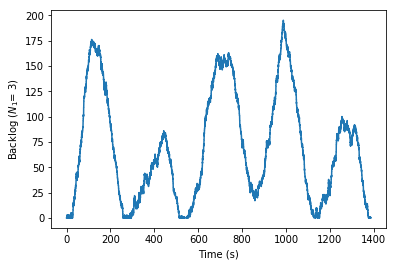

100%|██████████| 4104/4104 [00:01<00:00, 2921.31it/s]


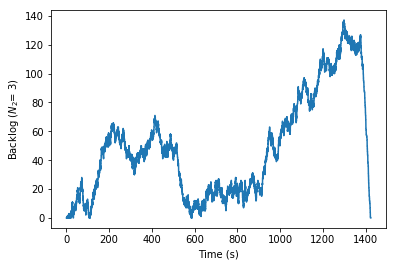

100%|██████████| 4104/4104 [00:01<00:00, 2976.85it/s]


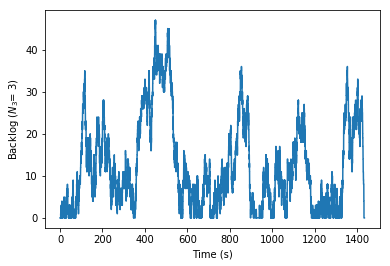

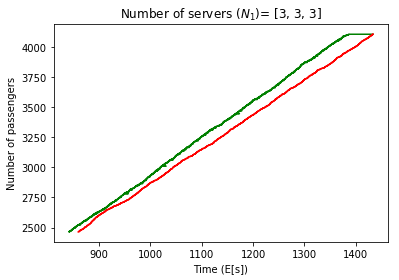

In [113]:
Ta = Arrival_Gen(ArrivalType, mean_Ta, lengthTa)
Ts = Service_Gen(ServiceType, mean_Ts[0], lengthTa)

job = Job(Ta, Ts, np.arange(1, lengthTa + 1), TotHistLength)
plt.figure()
for stage in range(stageNum):
    
    infQueueMultiServ_CHANjob(job, N[stage], TotHistLength, QLnoise, QLnoise_sigma)
    jobMatrix = np.array(list(job.dict.values()))
    jobIndex = np.array(list(job.dict.keys()))
    order = np.argsort(jobMatrix[:,0])
    Ta = np.sort(jobMatrix[:,0])
    Td = np.sort(jobMatrix[:,1])
    plt.step(*zip(*job.b[:,:2]), where='post')
    plt.ylabel('Backlog ($N_{%s}$= %s)'%(stage+1,N[stage]))
    plt.xlabel('Time (s)')
    plt.show()
         # \\\\\\\\  deep copy? ////////////
    featuresNum = np.shape(jobMatrix)[1]
    if stage==0:
        totalJobMatrix = np.hstack((jobMatrix[:,1].reshape(-1, 1), jobMatrix[:, -2*TotHistLength:]))
        e2eDelay = jobMatrix[:,3]
    else:
        totalJobMatrix = np.hstack((totalJobMatrix , jobMatrix[:, -2*TotHistLength:]))
        e2eDelay = e2eDelay + jobMatrix[:,3]
    
   # ********creating job matrix for the next stage************
    serviceHistory = np.zeros((lengthTa,TotHistLength))
    if stage+1 < stageNum:
        Ts = Service_Gen(ServiceType, mean_Ts[stage+1], lengthTa)
        delayHistory_Ta = np.zeros((np.shape(Ta)[0], TotHistLength))
        delayHistory = np.zeros((np.shape(Ta)[0], TotHistLength))
        job.dict = dict(zip(jobIndex , np.hstack((list(map(list,list(zip(jobMatrix[:,1] , np.zeros(lengthTa) ,
                                    Ts , np.zeros(lengthTa))))), delayHistory_Ta, delayHistory))))
    
X = np.append(np.append(0, totalJobMatrix[:,0]), Td[-1])
Y = np.append(range(0, lengthTa + 1), lengthTa)
plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'g', where='post', label='Cumalative arrival')
X = np.append(0, Td)
Y = range(0, lengthTa + 1)
plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'r', where='post', label='Cumulative departure')
plt.title('Number of servers ($N_{%s}$)= %s' % (1, N))
plt.ylabel('Number of passengers')
plt.xlabel('Time (E[s])')
plt.show()    
# ///////////////////Data set for delay estimation//////////////
for k in np.arange(lengthTa):
    if totalJobMatrix[k,-1]!=0:
        begin = k
        break
        
trainData = totalJobMatrix[begin:,:]
label = np.reshape(e2eDelay[begin:],(np.size(e2eDelay[begin:]),1))
data = np.hstack((trainData,label))

# Plotting End-to-End Delay

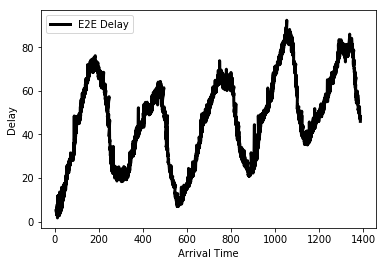

In [114]:
fig = plt.figure()
plt.plot(data[:, 0], label, c='k', lw=3.0, label='E2E Delay')
plt.legend()
plt.xlabel('Arrival Time')
plt.ylabel('Delay')
plt.show()